# Overfitting Design Pattern

The *Overfitting design pattern* refers to situations where overfitting is beneficial. In this notebook, we'll use overfitting on a batch as a way to gut check our ML model. 


We'll start by building our model and tf.data pipeline as usual.

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

In [2]:
df = pd.read_csv("./data/babyweight_train.csv")

Set up the features for the model

In [4]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]


y_train = df[LABEL][:N_TRAIN]
y_valid = df[LABEL][N_TRAIN:]

Create the input pipeline.

In [5]:
# train/validation dataset
trainds = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train.values))
evalds = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid.values))

In [6]:
# Examine the datasets.
for dict_slice in trainds.take(1):
        print("{}\n".format(dict_slice))

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



Set up the feature columns for the model.

In [7]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

Next, we build the model, a simple neural network.

In [8]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# create model
output = layers.Dense(1, activation="relu")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])   

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


## Overfit on a batch

We can inspect our train data pipeline by pulling a singe batch of 5 examples. 

In [14]:
for feature_batch, label_batch in trainds.batch(5).take(1):
    print("'babyweight': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
      print("  {!r:20s}: {}".format(key, value))

'babyweight': [[7.74924851]
 [7.56185559]
 [7.18706974]
 [6.37576862]
 [7.93664143]]
features:
  'is_male'           : [b'False' b'True' b'False' b'True' b'False']
  'mother_age'        : [12 12 12 12 12]
  'plurality'         : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)']
  'gestation_weeks'   : [40 40 34 36 35]
  'mother_race'       : [b'1.0' b'2.0' b'3.0' b'2.0' b'0.0']


For training, we'll take a larger batch and call it `single_batch`.

In [16]:
BATCH_SIZE = 256

single_batch = trainds.batch(BATCH_SIZE).take(1)

Then we train the model on the single batch. Note we must use `.repeat()` since we'll quickly run out of data training on just a single batch. Also, we've set the number of training examples to BATCH_SIZE.

In [17]:
# train the classifcation model
tf.random.set_seed(33)

NUM_TRAINING_EXAMPLES = BATCH_SIZE  # total number of training examples
NUM_VALID_EXAMPLES = X_valid.shape[0]
NUM_EPOCHS = 100
TOTAL_TRAINING_EXAMPLES = int(NUM_EPOCHS * NUM_TRAINING_EXAMPLES)

steps_per_epoch = (TOTAL_TRAINING_EXAMPLES // (BATCH_SIZE * NUM_EPOCHS))

evalds = evalds.batch(X_valid.shape[0]).take(int(NUM_VALID_EXAMPLES//BATCH_SIZE))

# train the model
history = model.fit(single_batch.repeat(),
                    validation_data=evalds, 
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    verbose=0
                   )

Lastly, we'll plot the validation and train loss curves. 

In [18]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

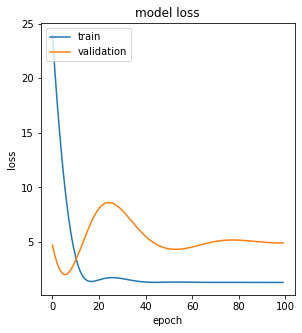

In [19]:
plot_curves(history, ['loss'])

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License